# Cloud Cover Classification Project

## Reference

1) https://www.kaggle.com/datasets/ryches/understanding-clouds-resized

2) https://github.com/milesial/Pytorch-UNet

## Setup the environment for Spark

In [2]:
import os
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64/"
os.environ["SPARK_HOME"] = "spark-2.3.1-bin-hadoop2.7/"

## Import Libraries

In [92]:
import matplotlib.pyplot as plt # Plotting cloud cover images with masks.
from skimage import io
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import albumentations as albu

import cv2 # Reading images
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [4]:
import findspark
findspark.init()

from pyspark import SparkContext
import pyspark
from pyspark.sql import SparkSession

sc = SparkContext.getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [5]:
spark = SparkSession.builder.getOrCreate() 
spark

## Exploratory Dataset Analysis

In [15]:
path = '../input/understanding_cloud_organization'
train_df = spark.read.csv(f'{path}/train.csv', header=True)

In [16]:
train_df.show(5)

+------------------+--------------------+
|       Image_Label|       EncodedPixels|
+------------------+--------------------+
|  0011165.jpg_Fish|264918 937 266318...|
|0011165.jpg_Flower|1355565 1002 1356...|
|0011165.jpg_Gravel|                null|
| 0011165.jpg_Sugar|                null|
|  002be4f.jpg_Fish|233813 878 235213...|
+------------------+--------------------+
only showing top 5 rows



In [17]:
num_train_images = len(os.listdir("../input/understanding_cloud_organization/train_images/"))
num_test_images = len(os.listdir("../input/understanding_cloud_organization/test_images/"))

print("The number of training images are: {}".format(num_train_images))
print("The number of testing images are: {}".format(num_test_images))

The number of training images are: 5546
The number of testing images are: 3698


### Number of images having Sugar, Gravel, Fish and Flower as Labels

In [18]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

get_label = udf(lambda s: s.split('_')[1])
train_df.filter(train_df.EncodedPixels.isNotNull()).withColumn('Image_Label',get_label(train_df.Image_Label)).groupby('Image_Label').count().show()

+-----------+-----+
|Image_Label|count|
+-----------+-----+
|     Flower| 2365|
|     Gravel| 2939|
|      Sugar| 3751|
|       Fish| 2781|
+-----------+-----+



In [19]:
train_df.show()

+------------------+--------------------+
|       Image_Label|       EncodedPixels|
+------------------+--------------------+
|  0011165.jpg_Fish|264918 937 266318...|
|0011165.jpg_Flower|1355565 1002 1356...|
|0011165.jpg_Gravel|                null|
| 0011165.jpg_Sugar|                null|
|  002be4f.jpg_Fish|233813 878 235213...|
|002be4f.jpg_Flower|1339279 519 13406...|
|002be4f.jpg_Gravel|                null|
| 002be4f.jpg_Sugar|67495 350 68895 3...|
|  0031ae9.jpg_Fish|3510 690 4910 690...|
|0031ae9.jpg_Flower|2047 703 3447 703...|
|0031ae9.jpg_Gravel|                null|
| 0031ae9.jpg_Sugar|658170 388 659570...|
|  0035239.jpg_Fish|                null|
|0035239.jpg_Flower|100812 462 102212...|
|0035239.jpg_Gravel|65400 380 66800 3...|
| 0035239.jpg_Sugar|                null|
|  003994e.jpg_Fish|2367966 18 236798...|
|003994e.jpg_Flower|                null|
|003994e.jpg_Gravel|353317 416 354717...|
| 003994e.jpg_Sugar|28011 489 29411 4...|
+------------------+--------------

### Only 266 images have 4 masks.

In [20]:
get_num_masks = udf(lambda s: s.split('_')[0])
train_df.filter(train_df.EncodedPixels.isNotNull()).withColumn('Image_Label',get_num_masks(train_df.Image_Label)).groupby('Image_Label').count().groupby('count').count().show()

+-----+-----+
|count|count|
+-----+-----+
|    1| 1348|
|    3| 1560|
|    2| 2372|
|    4|  266|
+-----+-----+



## Create new columns(Label and Image Name) for each row.

Split the Image_Label column and get the corresponding Image Name and Label for each row. Add the new columns into the dataframe

In [21]:
split_col = pyspark.sql.functions.split(train_df['Image_Label'], '_')
train_df = train_df.withColumn('Image_Name', split_col.getItem(0))
train_df = train_df.withColumn('Label', split_col.getItem(1))

In [22]:
train_df.show()

+------------------+--------------------+-----------+------+
|       Image_Label|       EncodedPixels| Image_Name| Label|
+------------------+--------------------+-----------+------+
|  0011165.jpg_Fish|264918 937 266318...|0011165.jpg|  Fish|
|0011165.jpg_Flower|1355565 1002 1356...|0011165.jpg|Flower|
|0011165.jpg_Gravel|                null|0011165.jpg|Gravel|
| 0011165.jpg_Sugar|                null|0011165.jpg| Sugar|
|  002be4f.jpg_Fish|233813 878 235213...|002be4f.jpg|  Fish|
|002be4f.jpg_Flower|1339279 519 13406...|002be4f.jpg|Flower|
|002be4f.jpg_Gravel|                null|002be4f.jpg|Gravel|
| 002be4f.jpg_Sugar|67495 350 68895 3...|002be4f.jpg| Sugar|
|  0031ae9.jpg_Fish|3510 690 4910 690...|0031ae9.jpg|  Fish|
|0031ae9.jpg_Flower|2047 703 3447 703...|0031ae9.jpg|Flower|
|0031ae9.jpg_Gravel|                null|0031ae9.jpg|Gravel|
| 0031ae9.jpg_Sugar|658170 388 659570...|0031ae9.jpg| Sugar|
|  0035239.jpg_Fish|                null|0035239.jpg|  Fish|
|0035239.jpg_Flower|1008

## Decode the Encoded Pixels to get the mask

In [23]:
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

## Plot Images and corresponding masks for some random images

In [24]:
rand_img_names = train_df.select('Image_Name').rdd.takeSample(withReplacement=False, num = 4)

In [25]:
rand_img_names = [img_name[0] for img_name in rand_img_names]
rand_img_names

['345e596.jpg', '3597a58.jpg', '6d42ca7.jpg', 'c3fcfa7.jpg']

In [28]:
rand_df = train_df.filter(train_df.Image_Name.isin(rand_img_names))

In [29]:
rand_df.show()

+------------------+--------------------+-----------+------+
|       Image_Label|       EncodedPixels| Image_Name| Label|
+------------------+--------------------+-----------+------+
|  345e596.jpg_Fish|268824 1 268833 2...|345e596.jpg|  Fish|
|345e596.jpg_Flower|                null|345e596.jpg|Flower|
|345e596.jpg_Gravel|                null|345e596.jpg|Gravel|
| 345e596.jpg_Sugar|601663 174 601839...|345e596.jpg| Sugar|
|  3597a58.jpg_Fish|                null|3597a58.jpg|  Fish|
|3597a58.jpg_Flower|1432631 947 14340...|3597a58.jpg|Flower|
|3597a58.jpg_Gravel|                null|3597a58.jpg|Gravel|
| 3597a58.jpg_Sugar|13809 1 13813 66 ...|3597a58.jpg| Sugar|
|  6d42ca7.jpg_Fish|                null|6d42ca7.jpg|  Fish|
|6d42ca7.jpg_Flower|                null|6d42ca7.jpg|Flower|
|6d42ca7.jpg_Gravel|11612 988 13012 9...|6d42ca7.jpg|Gravel|
| 6d42ca7.jpg_Sugar|183893 615 185293...|6d42ca7.jpg| Sugar|
|  c3fcfa7.jpg_Fish|                null|c3fcfa7.jpg|  Fish|
|c3fcfa7.jpg_Flower|5563

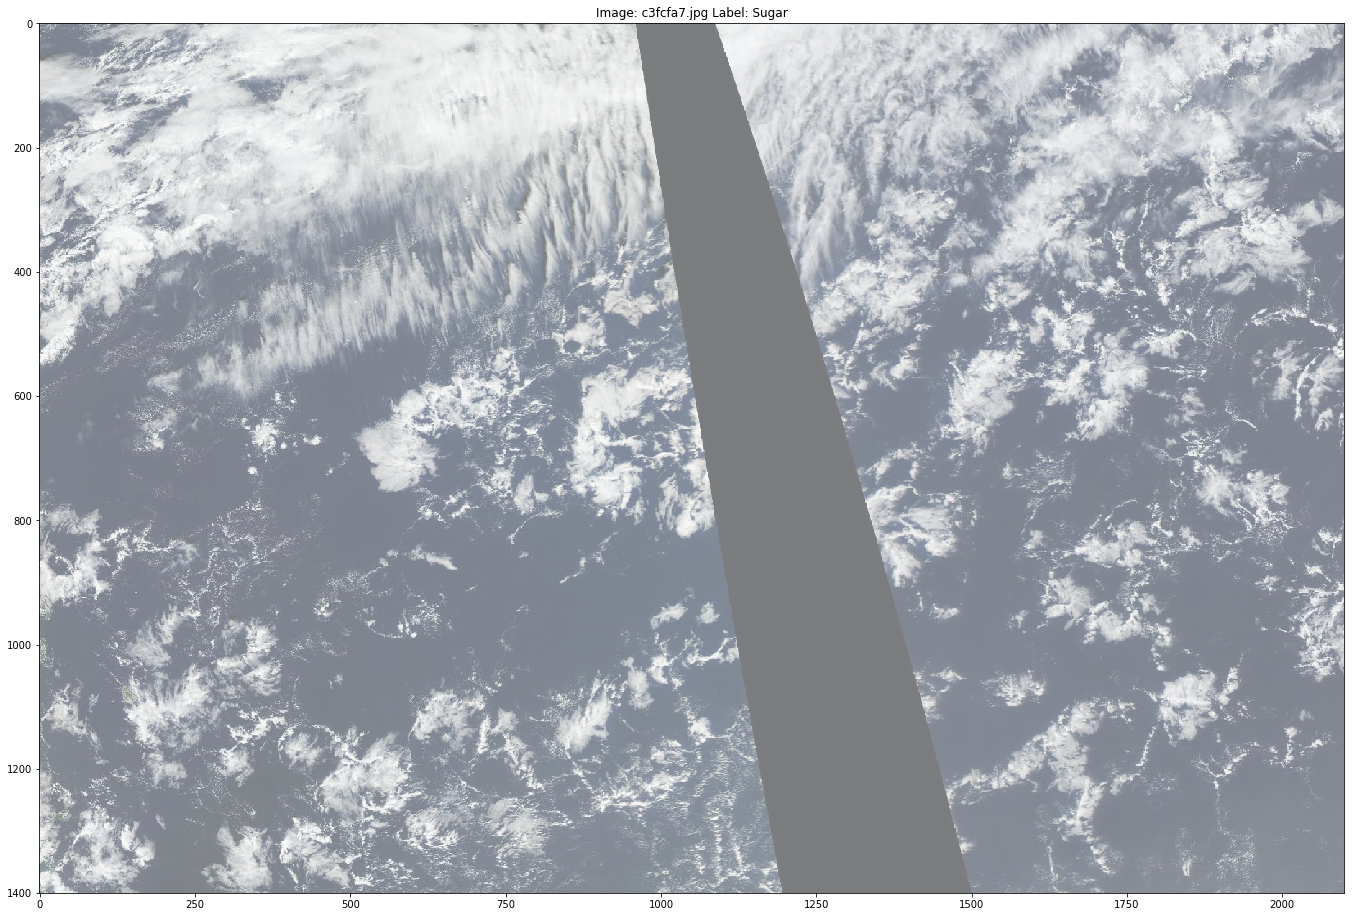

In [30]:
data_collect = rand_df.collect()


fig = plt.figure(figsize = (25, 16))
train_img_path = "../input/understanding_cloud_organization/train_images/"

for row in data_collect:
#     print(row["Image_Name"] + " " +  row["Label"])
    img = io.imread(train_img_path + row["Image_Name"])
    plt.imshow(img)
    
    mask = row['EncodedPixels']
    try:
        mask = rle_decode(mask)
    except:
        mask = np.zeros((1400, 2100))
    plt.imshow(mask, alpha=0.5, cmap = 'Blues')
    plt.title("Image: " + row['Image_Name'] + " Label: " + row['Label'])

In [31]:
rand_df.show()

+------------------+--------------------+-----------+------+
|       Image_Label|       EncodedPixels| Image_Name| Label|
+------------------+--------------------+-----------+------+
|  345e596.jpg_Fish|268824 1 268833 2...|345e596.jpg|  Fish|
|345e596.jpg_Flower|                null|345e596.jpg|Flower|
|345e596.jpg_Gravel|                null|345e596.jpg|Gravel|
| 345e596.jpg_Sugar|601663 174 601839...|345e596.jpg| Sugar|
|  3597a58.jpg_Fish|                null|3597a58.jpg|  Fish|
|3597a58.jpg_Flower|1432631 947 14340...|3597a58.jpg|Flower|
|3597a58.jpg_Gravel|                null|3597a58.jpg|Gravel|
| 3597a58.jpg_Sugar|13809 1 13813 66 ...|3597a58.jpg| Sugar|
|  6d42ca7.jpg_Fish|                null|6d42ca7.jpg|  Fish|
|6d42ca7.jpg_Flower|                null|6d42ca7.jpg|Flower|
|6d42ca7.jpg_Gravel|11612 988 13012 9...|6d42ca7.jpg|Gravel|
| 6d42ca7.jpg_Sugar|183893 615 185293...|6d42ca7.jpg| Sugar|
|  c3fcfa7.jpg_Fish|                null|c3fcfa7.jpg|  Fish|
|c3fcfa7.jpg_Flower|5563

## Splitting data into training and validation datasets

In [32]:
uniq_img_name_df = train_df.select('Image_Name').dropDuplicates(["Image_Name"])
uniq_img_name_df.count()

5546

In [33]:
get_num_masks = udf(lambda s: s.split('_')[0])
strat_df = train_df.filter(train_df.EncodedPixels.isNotNull()).withColumn('Image_Label',get_num_masks(train_df.Image_Label)).groupby('Image_Label').count()

In [34]:
strat_df.show()

+-----------+-----+
|Image_Label|count|
+-----------+-----+
|0451ee4.jpg|    3|
|12e0e0d.jpg|    4|
|1c51d97.jpg|    3|
|1d6d628.jpg|    4|
|2011d14.jpg|    2|
|2b78c19.jpg|    2|
|2c85439.jpg|    2|
|35250ae.jpg|    2|
|3d7696d.jpg|    2|
|5bfcce8.jpg|    1|
|69e0a69.jpg|    2|
|6b6426f.jpg|    2|
|7ef2a7c.jpg|    3|
|86672fb.jpg|    2|
|8cf636e.jpg|    1|
|9525fb0.jpg|    2|
|9db3361.jpg|    3|
|bbd2907.jpg|    2|
|be1c45f.jpg|    2|
|c06c8c1.jpg|    3|
+-----------+-----+
only showing top 20 rows



In [35]:
train_part = strat_df.stat.sampleBy("count", fractions = {1: 0.7, 2: 0.7, 3: 0.7, 4:0.7}, seed = 12)
valid_part = strat_df.subtract(train_part)

In [36]:
train_part.show()

+-----------+-----+
|Image_Label|count|
+-----------+-----+
|0451ee4.jpg|    3|
|12e0e0d.jpg|    4|
|1c51d97.jpg|    3|
|2011d14.jpg|    2|
|35250ae.jpg|    2|
|6b6426f.jpg|    2|
|7ef2a7c.jpg|    3|
|86672fb.jpg|    2|
|9db3361.jpg|    3|
|bbd2907.jpg|    2|
|be1c45f.jpg|    2|
|c06c8c1.jpg|    3|
|cbc45f3.jpg|    3|
|d441a18.jpg|    2|
|e6ae091.jpg|    2|
|f54d745.jpg|    2|
|08ece64.jpg|    2|
|1007e0c.jpg|    2|
|11388ad.jpg|    2|
|3874f5b.jpg|    3|
+-----------+-----+
only showing top 20 rows



In [37]:
valid_part.count()

1697

In [38]:
train_part.groupby('count').count().show()

+-----+-----+
|count|count|
+-----+-----+
|    1|  968|
|    3| 1067|
|    2| 1623|
|    4|  191|
+-----+-----+



In [39]:
valid_part.groupby('count').count().show()

+-----+-----+
|count|count|
+-----+-----+
|    1|  380|
|    3|  493|
|    2|  749|
|    4|   75|
+-----+-----+



In [40]:
train_img_ids = train_part.select("Image_Label").rdd.map(lambda row: row[0]).collect()
val_img_ids = valid_part.select("Image_Label").rdd.map(lambda row: row[0]).collect()

## UNet model definition

In [41]:
class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=3, n_classes=4).float()
if torch.cuda.is_available():
    model = model.to(device)

## Helper functions

In [54]:
def make_mask(df, image_name, shape: tuple = (350, 525)):
    """
        Create a mask based on the dataframe, image_name and convert 
        to the given shape
    """
    
    '''
        df (spark.Dataframe): Dataframe containing the image names
                            and corresponding masks.
        image_name(str): Name of the cloud image
        shape (tuple): Shape of the mask
    '''
    
    # Path where the masks are stored
    mask_path = "../input/understanding-clouds-resized/train_masks_525/train_masks_525/"

    # Store masks for 4 different labels
    masks = np.zeros((shape[0], shape[1], 4), dtype =np.float32)

    # Get masks from the dataframe
    req_df = train_df.filter((train_df.Image_Name).isin(image_name))
    
    data_collect = req_df.collect()

#     for idx,row in enumerate(data_collect):
        
#         mask = row['EncodedPixels']
    
#         try:
#             mask = rle_decode(mask)
#         except:
#             mask = np.zeros((1400, 2100))
#         masks[:, :, idx] = mask
    for idx, row in enumerate(data_collect):
        for classidx, classid in enumerate(["Fish", "Flower", "Gravel", "Sugar"]):
            mask = cv2.imread(
                mask_path + classid + image_name
            )
            if mask is None:
                continue
            if mask[:, :, 0].shape != (350, 525):
                mask = cv2.resize(mask, (525, 350))
            masks[:, :, classidx] = mask[:, :, 0]
    masks = masks / 255
    return masks
        
#     return masks

## Dataset Class Definition

In [102]:
class CloudCoverDataset(Dataset):
    """Cloud Cover Dataset"""
    
    def __init__(self, 
                 df,
                 split_type,
                 ids,
                 transforms = albu.Compose([albu.HorizontalFlip()]),
                ):
        """
        Args:
            data_path (string): Path to the folder containing the images
            transform (callable, optional): Optional transform to be applied
                on a sample.
            df (pandas.DataFrame): DataFrame containing the annotations for corresponding images
            split_type (string): train/valid or test split
            ids (list): List of image names used for either train/test.
        """
        self.transforms = transforms
        self.df = df
        if split_type != 'test':
            self.data_path = "../input/understanding-clouds-resized/train_images_525/train_images_525/"
        else:
            self.data_path = "../input/understanding-clouds-resized/test_images_525/test_images_525/"
        self.ids = ids
        self.transforms = transforms
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        image_name = self.ids[idx]
#         print(image_name)
        mask = make_mask(self.df, image_name)
        img_path = os.path.join(self.data_path, image_name)
#         print(img_path)
        img = cv2.imread(img_path)
#         print(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Perform some transformations like Flipping
        augmented = self.transforms(image=img, mask=mask)
        
        # Perform image transposing before passing into UNet
        img = np.transpose(augmented['image'], [2, 0, 1])
        mask = np.transpose(augmented['mask'], [2, 0, 1])
        
        return img, mask

In [103]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(
            scale_limit=0.5,
            rotate_limit=0,
            shift_limit=0.1,
            p=0.5,
            border_mode=0
        ),
        albu.GridDistortion(p=0.5),
        albu.Resize(320, 640),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(320, 640),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
    return albu.Compose(test_transform)

## Dataloader and other arguments for training

In [104]:
batch_size = 8
num_workers = 2

train_dataset = CloudCoverDataset(df=train_df, 
                                  split_type= 'train',
                                  ids = train_img_ids,
#                                   transforms = None,
                                  transforms=get_training_augmentation(),
                                 )
valid_dataset = CloudCoverDataset(df=train_df, 
                                  split_type='valid',
                                  ids = val_img_ids,
#                                   transforms = None
                                  transforms=get_validation_augmentation(),
                                 )

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                         shuffle = True,
                         num_workers=num_workers)

valid_loader = DataLoader(valid_dataset, 
                          batch_size=batch_size,
                         shuffle = False,
                         num_workers=num_workers)

optimizer = torch.optim.Adam([
    {'params': model.parameters(), 'lr': 1e-2}, 
#     {'params': model.encoder.parameters(), 'lr': 1e-3},  
])
scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=2)

## Loss function definition

In [105]:
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - f_score(y_pr, y_gt, beta=1., 
                           eps=self.eps, threshold=None, 
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce)

In [106]:
criterion = BCEDiceLoss(eps=1.0, activation=None)

In [107]:
n_epochs = 32
train_loss_list = []
valid_loss_list = []
dice_score_list = []
lr_rate_list = []
valid_loss_min = np.Inf # track change in validation loss
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    model.train()
    
    for i, (data, mask) in enumerate(train_loader):
        data = data.to(device)
        mask = mask.to(device)
        
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
    train_loss_list.append(train_loss)
    
    model.eval()
    
    with torch.no_grad():
    for i, (data, mask) in enumerate(valid_loader):
        data = data.to(device)
        mask = mask.to(device)
        
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = criterion(output, mask)
        valid_loss += loss.item()*data.size(0)
        dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item()
        dice_score +=  dice_cof * data.size(0)    
    valid_loss_list.append(valid_loss)
    dice_score_list.append(dice_score)

tensor(1.3905, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3598, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [109]:
train_part.count()

3849

In [110]:
valid_part.count()

1697

In [ ]:
len(os.listdir())

In [85]:
image_name = "f65929d.jpg"
mask = make_mask(train_df, image_name)
train_data_path = "../input/understanding-clouds-resized/train_images_525/train_images_525/"
img_path = os.path.join(train_data_path, image_name)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



In [81]:
img_path

'/kaggle/input/understanding-clouds-resized/train_images_525/train_images_525/train_images_525/f65929d.jpg'

In [83]:
!ls '../understanding-clouds-resized/train_images_525/train_images_525/train_images_525/f65929d.jpg'

ls: cannot access '../understanding-clouds-resized/train_images_525/train_images_525/train_images_525/f65929d.jpg': No such file or directory


In [84]:
!ls ../../data_collect

__notebook_source__.ipynb  spark-2.3.1-bin-hadoop2.7.tgz
spark-2.3.1-bin-hadoop2.7  spark-warehouse


In [ ]:
train_transforms
augmented = .transforms(image=img, mask=mask)


In [ ]:
image_name = "7d07b03.jpg"

In [139]:
train_data_path = "../input/understanding_cloud_organization/train_images/"
mask = make_mask(train_df, image_name)
img_path = os.path.join(train_data_path, image_name)
img = cv2.imread(img_path)


In [ ]:
!ls '../input/understanding-clouds-resized/train_images_525/train_images_525/'

In [140]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


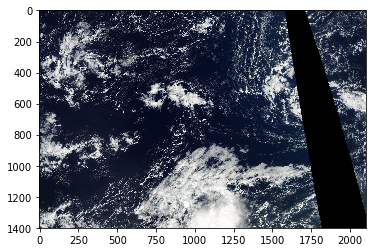

In [141]:
plt.imshow(img)

In [44]:
# make_mask(train_df, image_name)

req_df = train_df.filter((train_df.Image_Name).isin(image_name))

KeyError: 'c'

In [45]:
image_name

NameError: name 'image_name' is not defined

In [97]:
    data_collect = req_df.collect()


In [99]:
    for idx,row in enumerate(data_collect):

        mask = row['EncodedPixels']

        try:
            mask = rle_decode(mask)
        except:
            mask = np.zeros((1400, 2100))
        masks[:, :, idx] = mask


In [100]:
masks

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0.